Clothing_Categorization

Parker Williamson
1/22/2018

This program takes a set of training data and classification data and using different methods of computer vision categorizes the test set based on the training set. The data that was used to analyze different techniques was clothing data from https://www.kaggle.com/zalando-research/fashionmnist.

(used https://www.youtube.com/watch?list=PLQVvvaa0QuDfKTOs3Keq_kaG2P55YRn5v&time_continue=1493&v=mynJtLhhcXk as a template for CNN)

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import tensorflow as tf
from numpy import genfromtxt
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from scipy import stats

In [2]:
%matplotlib inline

Dictionary definitions shows the true categories that the dataset lists

In [3]:
definitions = {0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle boot'}

open data from the adjacent rawData folder

In [4]:
train_data = genfromtxt('rawData/fashion-mnist_train.csv', skip_header=True, delimiter=',')

In [123]:
test_data = genfromtxt('rawData/fashion-mnist_test.csv', skip_header=True, delimiter=',')

In [6]:
classification,rawData =np.split(train_data,indices_or_sections=[1],axis=1)

Select preprocessing mode

In [7]:
preclassifier_data_Norm= rawData.astype('float32')/255 #preprocessing.normalize(rawData)

preclassifier_data_STD = (rawData - np.mean(rawData, axis=1, keepdims=1)) / np.std(rawData, axis=1, keepdims=1)

preclassifier_data_raw = rawData

Initialize and save the classifers:

In [8]:
from sklearn.externals import joblib 
import pickle

In [10]:
clf_MLP = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(784, 100, 100), random_state=1)
clf_MLP.fit(preclassifier_data_Norm, classification.ravel())

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(784, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [30]:
joblib.dump(clf_MLP, 'TrainedModels/MLPmodel.pkl')

['TrainedModels/MLPmodel.pkl']

In [11]:
clf_SVM = svm.LinearSVC()
clf_SVM.fit(preclassifier_data_Norm, classification.ravel())

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [31]:
joblib.dump(clf_SVM, 'TrainedModels/SVMmodel.pkl')

['TrainedModels/SVMmodel.pkl']

In [12]:
clf_LogReg = LogisticRegression()
clf_LogReg.fit(preclassifier_data_STD, classification.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
joblib.dump(clf_LogReg, 'TrainedModels/LogRegmodel.pkl')

['TrainedModels/LogRegmodel.pkl']

Load the models and predict the results:

In [9]:
clf_MLP = joblib.load('TrainedModels/MLPmodel.pkl')
clf_SVM = joblib.load('TrainedModels/SVMmodel.pkl')
clf_LogReg = joblib.load('TrainedModels/LogRegmodel.pkl')

In [10]:
classification_test,rawData_test =np.split(test_data,indices_or_sections=[1],axis=1)

In [11]:
preclassifier_data_test_Norm = rawData_test.astype('float32')/255 #preprocessing.normalize(rawData_test)

preclassifier_data_test_STD = (rawData_test - np.mean(rawData_test, axis=1, keepdims=1)) / np.std(rawData_test, axis=1, keepdims=1)

preclassifier_data_test_raw = rawData_test

In [12]:
results_MLP = clf_MLP.predict(preclassifier_data_test_Norm)

In [13]:
results_SVM = clf_SVM.predict(preclassifier_data_test_Norm)

In [14]:
results_LogReg = clf_LogReg.predict(preclassifier_data_test_STD)

Analyze the results:

In [15]:
print(results_MLP)

[ 0.  1.  2. ...,  8.  8.  1.]


Show which answers are confused:

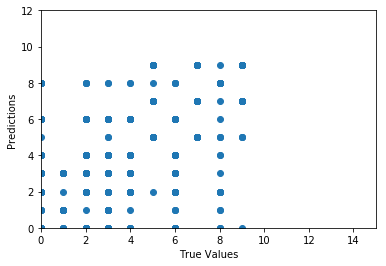

In [16]:
## The line / model
#%pylab inline
plt.scatter(classification_test, results_MLP)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis([0, 15, 0, 12])
plt.show()

Convolutional Neural Network analysis and predictions:

In [45]:
#https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
#(x_train y_train), (x_test, y_test) = mnist.load_data()
x_train = preclassifier_data_STD
y_train = classification.ravel()
x_test = preclassifier_data_test_STD
y_test = classification_test.ravel()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [23]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('preprocessing: ', mode)

Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 479s 8ms/step - loss: 0.5743 - acc: 0.7978 - val_loss: 0.3602 - val_acc: 0.8649
Epoch 2/12
60000/60000 [==============================] - 519s 9ms/step - loss: 0.3748 - acc: 0.8690 - val_loss: 0.2950 - val_acc: 0.8945
Epoch 3/12
60000/60000 [==============================] - 532s 9ms/step - loss: 0.3266 - acc: 0.8842 - val_loss: 0.2612 - val_acc: 0.9079
Epoch 4/12
60000/60000 [==============================] - 533s 9ms/step - loss: 0.2945 - acc: 0.8964 - val_loss: 0.2484 - val_acc: 0.9113
Epoch 5/12
60000/60000 [==============================] - 534s 9ms/step - loss: 0.2673 - acc: 0.9047 - val

Save and load the trained CNN to save time:

In [28]:
model.save('TrainedModels/CNNmodel.h5')

In [18]:
from keras.models import load_model
model = load_model('TrainedModels/CNNmodel.h5')

Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [24]:
results_CNN = model.predict_classes(x_test).astype(int)

10000/10000 [==============================] - 21s 2ms/step


Compare all the model predictions results:

In [26]:
comp= np.equal(list(classification_test.ravel()), list(results_MLP))
print(comp.sum())
print('Percentage: {}'.format(100*(comp.sum()/(len(comp)))))

8980
Percentage: 89.8


In [27]:
comp= np.equal(list(classification_test.ravel()), list(results_SVM))
print(comp.sum())
print('Percentage: {}'.format(100*(comp.sum()/(len(comp)))))

8475
Percentage: 84.75


In [28]:
comp= np.equal(list(classification_test.ravel()), list(results_LogReg))
print(comp.sum())
print('Percentage: {}'.format(100*(comp.sum()/(len(comp)))))

8519
Percentage: 85.19


In [29]:
comp= np.equal(list(classification_test.ravel()), list(results_CNN))
print(comp.sum())
print('Percentage: {}'.format(100*(comp.sum()/(len(comp)))))

9277
Percentage: 92.77


Calculate the Precision and Recall of the CNN model since it is the most accurate:

In [196]:
from sklearn.metrics import recall_score
#precision, recall, _ = precision_recall_curve(classification_test.ravel(), results_CNN)
recall = recall_score(classification_test.ravel(), results_CNN, average='macro')
from sklearn.metrics import precision_score
precision = precision_score(classification_test.ravel(), results_CNN, average='macro')
print('Precision: ', precision)
print('Recall: ', recall)

Precision:  0.929686712277
Recall:  0.9277


In [30]:
#print(np.shape(list(results_MLP)))
results = np.transpose(np.vstack((results_MLP,results_SVM,results_LogReg,results_CNN)))
#print(np.shape(results))

(10000,)
(10000, 4)


Visualize the Confusion maticies to visualize results in an understandable way (first confusion matrix is sum of all 4 models):

In [31]:
confusion = np.zeros((10,10))

for place, truth in enumerate(classification_test.astype(int)):
    for prediction in results[place,:].astype(int):
        confusion[truth, prediction] += 1
    
print(confusion.astype(int))

[[3378   13   63  126   12    7  349    1   51    0]
 [  14 3910    9   45    2    2   16    2    0    0]
 [  66   13 3173   49  393    0  276    0   30    0]
 [  98   53   39 3606   93    4   91    2   14    0]
 [   7    9  207  124 3388    2  252    0   11    0]
 [   4    6    1    0    0 3738    0  147   22   82]
 [ 562   19  308  136  282    1 2638    0   54    0]
 [   0    0    0    0    0   82    0 3747    2  169]
 [  18    8   25   21   10   23   41   13 3838    3]
 [   1    0    0    0    2   28    0  129    5 3835]]


Compare the CNN confusion matrix to the net results confusion matricies. Multiplied all by 4 to make it more directly comparable to the net result confusion matrix:

In [32]:
confusionCNN = np.zeros((10,10))

for place, truth in enumerate(classification_test.astype(int)):
    confusionCNN[truth, results[place,3].astype(int)] += 1
    
print(np.multiply(confusionCNN,4).astype(int)) # multiplied by 4 to allow a 1 for 1 comparision with the confusion matrix of all 4 models together

[[3456    0   48   52    0    4  412    0   28    0]
 [   8 3944    4   32    4    0    8    0    0    0]
 [  48    0 3396   52  232    0  268    0    4    0]
 [  36   16   12 3764   60    0  112    0    0    0]
 [   0   12   64   92 3580    0  248    0    4    0]
 [   0    0    0    0    0 3908    0   48    8   36]
 [ 296    0  100   68  140    0 3384    0   12    0]
 [   0    0    0    0    0   20    0 3836    0  144]
 [  16    8    8    0    8    4   20    8 3924    4]
 [   0    0    0    0    0    4    0   80    0 3916]]


In [ ]:
Look for commonly confused classification pairs. Find them by looking for outliers based on 95% percentile.

In [33]:
incorrectClass = confusion[~np.eye(confusion.shape[0],dtype=bool)]
percentileLims = np.percentile(incorrectClass,[2.5,97.5])
print('95% percentiles: ', percentileLims)

outliers = incorrectClass[(percentileLims[0]>incorrectClass)|(percentileLims[1]<incorrectClass)]
print('outlier counts: ',outliers)

outIndex = np.zeros((len(outliers),2))
#finds the position of the outliers in the confusion matrix
for idx,outlay in enumerate(outliers):
    outIndex[idx,:] = np.argwhere(confusion==outlay)
    #print(np.argwhere(confusion==outlay))

print(outIndex)
for pair in zip(*np.transpose(outIndex)) :
    print(definitions[pair[0]],' is commonly classified as a ',definitions[pair[1]])
    
#for pair in range(len(outliers)):
#    print(definitions[int(outIndex[pair,0])],' is commonly classified as a ',definitions[int(outIndex[pair,1])])

95% percentiles:  [   0.     339.775]
outlier counts:  [ 349.  393.  562.]
[[ 0.  6.]
 [ 2.  4.]
 [ 6.  0.]]
T-shirt/top  is commonly classified as a  Shirt
Pullover  is commonly classified as a  Coat
Shirt  is commonly classified as a  T-shirt/top


All confuse the same 3 categories.


Make a list of all the images that were confused in unusual numbers.

In [37]:
confusion_Net_Images = np.zeros((len(outIndex),784))
print(outIndex)
for place, imageCat in enumerate(classification_test):
    for pairNum, badPair in enumerate(zip(*np.transpose(outIndex))):
        # The image category is in the outlier matrix and the classification is one of the most commonly confused then save to a bad image array
        if((badPair[0]==int(imageCat)) & ((results[place,0]==badPair[1]) or (results[place,1]==badPair[1]) or (results[place,2]==badPair[1]) or (results[place,3]==badPair[1]))):
            confusion_Net_Images[pairNum,:] += rawData_test[place]
            lastplace= place

[[ 0.  6.]
 [ 2.  4.]
 [ 6.  0.]]


Show one of the most commonly confused images:

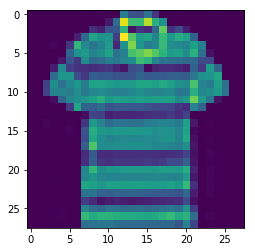

In [39]:
plt.imshow(rawData_test[lastplace][0:784].reshape((28,28)))
plt.show()

Look at which classifiers classified it as what:

In [40]:
print('Using MLP: ',definitions[int(classification_test[lastplace])],' is classified as a ',definitions[int(results[lastplace,0])])
print('Using SVM: ',definitions[int(classification_test[lastplace])],' is classified as a ',definitions[int(results[lastplace,1])])
print('Using LogReg: ',definitions[int(classification_test[lastplace])],' is classified as a ',definitions[int(results[lastplace,2])])
print('Using CNN: ',definitions[int(classification_test[lastplace])],' is classified as a ',definitions[int(results[lastplace,3])])

Using MLP:  T-shirt/top  is classified as a  T-shirt/top
Using SVM:  T-shirt/top  is classified as a  Shirt
Using LogReg:  T-shirt/top  is classified as a  Shirt
Using CNN:  T-shirt/top  is classified as a  T-shirt/top


Show the average images of each class:

Type:  T-shirt/top


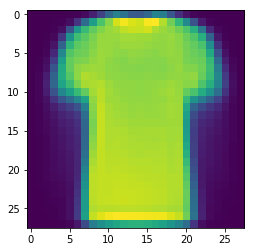

Type:  Trouser


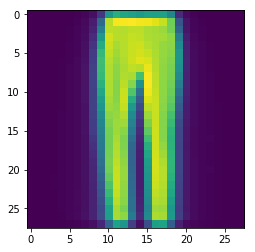

Type:  Pullover


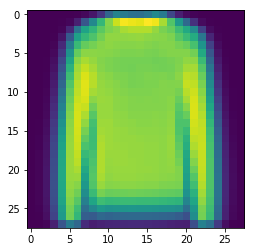

Type:  Dress


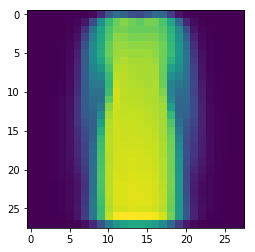

Type:  Coat


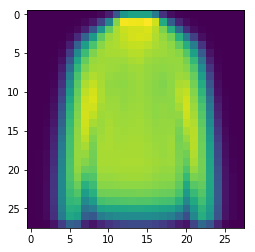

Type:  Sandal


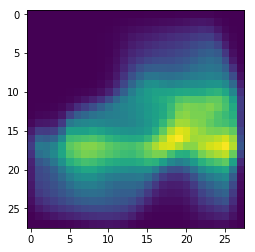

Type:  Shirt


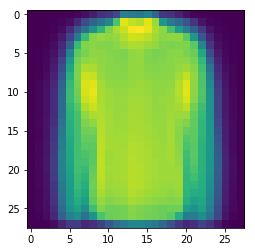

Type:  Sneaker


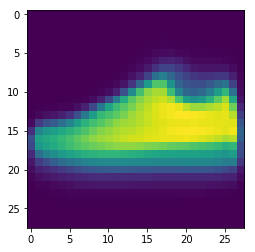

Type:  Bag


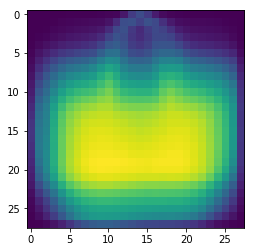

Type:  Ankle boot


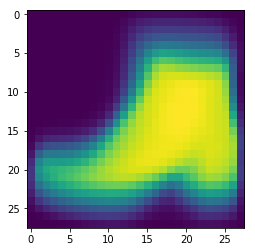

In [41]:
netImage = np.zeros((10,784))
for category in range(10):
    netImage[category,:] = np.sum(rawData[classification.ravel()==category],axis=0).ravel()
    print('Type: ',definitions[category])
    plt.imshow(netImage[category][0:784].reshape((28,28)))
    plt.show()

Show an array of images, where there is the true average image of a class, the average image from the confusion matrix, and the average image of the class those were stated to be.

Common mix up image matrix:
T-shirt/top  is commonly classified as a  Shirt


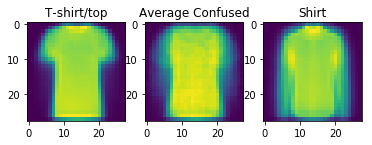

Pullover  is commonly classified as a  Coat


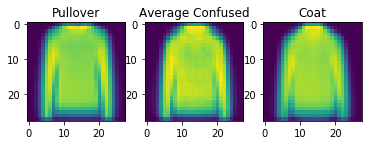

Shirt  is commonly classified as a  T-shirt/top


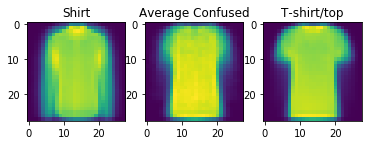

In [42]:
print('Common mix up image matrix:')
#plt.subplot((len(outIndex),3))
for ind,pairset in enumerate(zip(*np.transpose(outIndex))):
    print(definitions[pairset[0]],' is commonly classified as a ',definitions[pairset[1]])
    #fig = plt.figure()
    
    plt.subplot(131)
    plt.imshow(netImage[int(pairset[0])][0:784].reshape((28,28)))
    plt.title(definitions[pairset[0]])
    
    plt.subplot(132)
    plt.imshow(confusion_Net_Images[ind][0:784].reshape((28,28)))
    plt.title('Average Confused')
    
    plt.subplot(133)
    plt.imshow(netImage[int(pairset[1])][0:784].reshape((28,28)))
    plt.title(definitions[pairset[1]])
    plt.show()

Test ensambling:

First predict the results of the training data inorder to train the ensamble method.

In [197]:
from sklearn.ensemble import RandomForestClassifier

ensembler = RandomForestClassifier(n_estimators=20)

ensemble_data_MLP = clf_MLP.predict(preclassifier_data_Norm)
ensemble_data_SVM = clf_MLP.predict(preclassifier_data_Norm)
ensemble_data_LogReg = clf_MLP.predict(preclassifier_data_Norm)
ensemble_data_CNN = model.predict_classes(x_train).astype(int)

60000/60000 [==============================] - 136s 2ms/step


Predict the test data based on all the previous results and train the ensamble model (Random Forest)

In [202]:
ensemble_data = np.transpose(np.vstack((ensemble_data_MLP,ensemble_data_SVM,ensemble_data_LogReg,ensemble_data_CNN)))
ensembler.fit(ensemble_data,classification)

ensemblation = ensembler.predict(results)

comp= np.equal(list(classification_test.ravel()), list(ensemblation))
print(comp.sum())
print('Percentage: {}'.format(100*(comp.sum()/(len(comp)))))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


8647
Percentage: 86.47


Ensambling wasn't better than the straight CNN.

Try using a pretrained model to extract features from the image VGG19.

In [171]:
from keras import applications
from keras.datasets import cifar10

vgg_model = applications.VGG19(include_top=False, weights='imagenet')

batch_size = 128
num_classes = 10
epochs = 50

bottleneck_path = 'cifar10_cnn\bottleneck_features_train_vgg19.npy' #r'F:\work\kaggle\cifar10_cnn\bottleneck_features_train_vgg19.npy'

# the data, shuffled and split between train and test sets
(x_train_vgg, y_train_vgg), (x_test_vgg, y_test_vgg) = cifar10.load_data()

norm_train_data_vgg = preclassifier_data_Norm.reshape(preclassifier_data_Norm.shape[0], img_rows, img_cols,1)
norm_test_data_vgg = preclassifier_data_test_Norm.reshape(preclassifier_data_test_Norm.shape[0], img_rows, img_cols,1)

In [172]:
print('x_train shape:', norm_train_data_vgg.shape)
print(norm_train_data_vgg.shape[0], 'train samples')
print(norm_test_data_vgg.shape[0], 'test samples')
#print('x_train shape:', np.repeat(norm_train_data_vgg,3,axis=3).shape)
print(np.max(norm_train_data_vgg), ' max')
print(np.min(norm_train_data_vgg), ' min')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
1.0  max
0.0  min


vgg_model expects 32x32x3 color images and categorical classified solutions.

In [72]:
# convert class vectors to binary class matrices
y_train_vgg = keras.utils.to_categorical(y_train, num_classes)
y_test_vgg = keras.utils.to_categorical(y_test, num_classes)

y_train_vgg.shape

(600000, 10)

In [230]:
x_train_resized = np.zeros((len(norm_train_data_vgg),32,32,3))
for place, image in enumerate(np.repeat(norm_train_data_vgg,3,axis=3)):
    x_train_resized[place] = resize(image, (32, 32))

C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [232]:
x_test_resized = np.zeros((len(x_test),32,32,3))
for place, image in enumerate(np.repeat(norm_test_data_vgg,3,axis=3)):
    x_test_resized[place] = resize(image, (32, 32))

C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Predict the training data in order to train the post VGG filter classifier

In [233]:
import os
bottleneck_features_train_save = vgg_model.predict(x_train_resized,verbose=1)

60000/60000 [==============================] - 4312s 72ms/step


In [234]:
print(bottleneck_features_train_save.shape)

(60000, 1, 1, 512)


In [235]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
clf_model = Sequential()
clf_model.add(Flatten(input_shape=bottleneck_features_train_save.shape[1:]))
clf_model.add(Dense(512, activation='relu'))
clf_model.add(Dropout(0.5))
clf_model.add(Dense(256, activation='relu'))
clf_model.add(Dropout(0.5))
clf_model.add(Dense(num_classes, activation='softmax'))

In [236]:
clf_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [237]:
print(y_test_vgg.shape)

(10000, 1)


In [238]:
bottleneck_features_test_save = vgg_model.predict(x_test_resized,verbose=1)

10000/10000 [==============================] - 536s 54ms/step


Scale the bottleneck features 0-1

In [239]:
bottleneck_features_train_save2 = (bottleneck_features_train_save/np.max(bottleneck_features_train_save))
bottleneck_features_test_save2 = (bottleneck_features_test_save/np.max(bottleneck_features_test_save))

In [240]:
clf_model.fit(bottleneck_features_train_save2,y_train,
          batch_size=batch_size,
          epochs=12,
          verbose=1)

Epoch 1/12
60000/60000 [==============================] - 30s 495us/step - loss: 1.0472 - acc: 0.6361
Epoch 2/12
60000/60000 [==============================] - 22s 361us/step - loss: 0.6494 - acc: 0.7672
Epoch 3/12
60000/60000 [==============================] - 22s 362us/step - loss: 0.5807 - acc: 0.7908
Epoch 4/12
60000/60000 [==============================] - 23s 383us/step - loss: 0.5433 - acc: 0.8023
Epoch 5/12
60000/60000 [==============================] - 25s 409us/step - loss: 0.5110 - acc: 0.8161
Epoch 6/12
60000/60000 [==============================] - 23s 389us/step - loss: 0.4935 - acc: 0.8234
Epoch 7/12
60000/60000 [==============================] - 23s 378us/step - loss: 0.4778 - acc: 0.8306
Epoch 8/12
60000/60000 [==============================] - 23s 381us/step - loss: 0.4645 - acc: 0.8346
Epoch 9/12
60000/60000 [==============================] - 23s 390us/step - loss: 0.4515 - acc: 0.8376
Epoch 10/12
60000/60000 [==============================] - 22s 371us/step - loss: 

In [241]:
score = clf_model.evaluate(bottleneck_features_test_save2, y_test, verbose=1)

10000/10000 [==============================] - 3s 264us/step


In [242]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.38985661099
Test accuracy: 0.8571


The VGG feature extraction was decent but not better than a numbe of the other classifiers.